# Data Preprocessing

In [ ]:
import pandas as pd
import dotenv
import googlemaps
import os
from sklearn.preprocessing import MinMaxScaler
# Initialize google maps client
dotenv.load_dotenv()

gmaps_key = os.getenv("GOOGLE_MAPS_API_KEY")
gmaps = googlemaps.Client(key=gmaps_key)

# Load in the dataset
rides = pd.read_csv("RideShares.csv")

# We want to change Airport into a new column consisting of the coordinates of said airport
## We can use Google Map's API called Geocoding API / GeoLocation API: https://github.com/googlemaps/google-maps-services-python

def get_airport_coordinates(airport_name):
    """
    This function will use OpenStreetMapAPI in order to query for the coordinates of an aiport 
    
    input: airport name we will pass into the API
    output: a tuple that holds both (lat, long)
    """
    try:
        geocode_result = gmaps.geocode(f'{airport_name} Airport')
        if geocode_result: 
            location = geocode_result[0]["geometry"]["location"]
            return location ["lat"], location["lng"]
    except Exception as e:
        print(f"Error fetching coordinates for {airport_name}: {e}")
    return None, None
    
# append coordinates to new columns
rides[['latitude', 'longitude']] = rides['Airport'].apply(lambda x: pd.Series(get_airport_coordinates(x)))

# drop any rows with missing coordinates (if any)
rides.dropna(subset=['latitude', 'longitude'], inplace=True)
    
# Make this coordinates into a normalized range (Still be able to use Euclidian Distances)
scaler = MinMaxScaler()
rides[["latitude", "longitude"]] = scaler.fit_transform(rides[["latitude", "longitude"]])

ModuleNotFoundError: No module named 'dotenv'

In [1]:
import pandas as pd
from faker import Faker
import random
import csv
from datetime import datetime
from scipy.stats import truncnorm

# Load existing data
df = pd.read_csv('RideShares.csv')
df['FlightDate'] = pd.to_datetime(df['FlightDate'], errors='coerce', format='%m/%d/%Y')

fake = Faker()
random.seed(42)
fake.seed_instance(42)

def generate_data():
    """
    Generate synthetic data based on real dataset's distributions
    """

#min time for range and max time for range (these will be given in time not time intervals)
#prices might vary for ontario vs lax

    # Use real airport choices
    airport = random.choice(['LAX', 'ONT'])

    #min_wait (in .25hr increments)
    min_wait = random.choice([x / 60 for x in range(15, 121, 15)])

    #max_wait
    max_wait = random.choice([x / 60 for x in range(120, 301, 15)])

    #max spending range
    if random.random() < 0.75:  
        max_spending_range = random.randrange(10, 41, 5)
    else:  
        max_spending_range = random.randrange(40, 101, 5)

    # Bags within real observed range
    def truncated_normal(mean, std, lower=0, upper=float('inf')):
        a, b = (lower - mean) / std, (upper - mean) / std  
        return truncnorm.rvs(a, b, loc=mean, scale=std)

    mean_bag_number = df['BagNumber'].mean()
    std_bag_number = df['BagNumber'].std()
    bag_no = round(truncated_normal(mean_bag_number, std_bag_number))
    

    # Dropoff within real observed range
    dropoff_range = fake.random_int(0, 10) / 10    

    # Define date ranges for breaks
    end_of_winter_break_start = datetime(2025, 1, 18)
    end_of_winter_break_end = datetime(2025, 1, 20)
    start_of_winter_break_start = datetime(2024, 12, 11)
    start_of_winter_break_end = datetime(2024, 12, 14)
    spring_break_start = datetime(2024, 3, 14)
    spring_break_end = datetime(2024, 3, 23)
    thanksgiving_start = datetime(2024, 11, 30)
    thanksgiving_end = datetime(2024, 12, 1)

    # Randomly choose one of these two periods
    period_choice = random.choice([('spring_break', spring_break_start, spring_break_end),
                                   ('end_of_winter_break', end_of_winter_break_start, end_of_winter_break_end),
                                   ('start_of_winter_break',start_of_winter_break_start,start_of_winter_break_end),
                                ('thanksgiving', thanksgiving_start, thanksgiving_end)])

    # Sample a date based on the chosen period
    period, start_date, end_date = period_choice
    flight_date = fake.date_between_dates(start_date, end_date)

    # Convert date to string in the desired format
    flight_date_str = flight_date.strftime('%m/%d/%Y')  # Convert to string in the format "%m/%d/%Y"

    customer = {
        'FlightDate': flight_date_str,  # Use the formatted string here
        'FlightTime': fake.time(),
        'Airport': airport,
        'MinWaitTime': min_wait,
        'MaxWaitTime': max_wait,
        'BagNumber': bag_no,
        'MaxSpendingRange': max_spending_range,
        'DropOffRange': dropoff_range
    }

    return customer

# Generate synthetic customer data
synthetic_customers = [generate_data() for i in range(10000)]

# Write synthetic data to CSV
with open('synthetic_customer_data.csv', 'w', newline='') as csvfile:
    fieldnames = ['FlightDate', 'FlightTime', 'Airport', 'MinWaitTime', 'MaxWaitTime', 'BagNumber', 'MaxSpendingRange', 'DropOffRange']
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)

    writer.writeheader()
    for customer in synthetic_customers:
        writer.writerow(customer)

In [2]:
#Normalizing num_bags, price_range, dropoff_distance to between 0 and 1.
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

df2 = pd.read_csv('attempt1.csv')
features = ['BagNumber', 'MaxSpendingRange','DropOffRange', 'latitude', 'longitude', 'MinWaitTime', 'MaxWaitTime', 'ElapsedTime', 'datetime_sin', 'datetime_cos']

def normalize_dataframe(df2, features):
    df_normalized = df2.copy()
    scaler = MinMaxScaler()
    df_normalized[features] = scaler.fit_transform(df_normalized[features])
   
    return df_normalized

df2_normalized = normalize_dataframe(df2, features)
df2_normalized.to_csv("normalized_synthetic_data.csv", index=False)


# standard scalar
df3 = pd.read_csv('normalized_synthetic_data.csv')
def standard_scalar(df3, features):
    df = df3.copy()
    scaler2 = StandardScaler()
    df[features] = scaler2.fit_transform(df[features])
    return df

df3_standard_scalar = standard_scalar(df3, features)
df3_standard_scalar.to_csv("standard_scalar_data.csv", index=False)

In [3]:
# Cyclical Encoding for Date & Time
import pandas as pd
import numpy as np
import sklearn.preprocessing

# Load CSV
df = pd.read_csv("normalized_synthetic_data.csv")

# ensure date and time are in a consistent format 
# Date: MM/DD/YYYY
# Time: HH:MM:SS
df['FlightDate'] = pd.to_datetime(df['FlightDate'], errors='coerce', format='%m/%d/%Y')
df['FlightTime'] = pd.to_datetime(df['FlightTime'], errors='coerce', format='%H:%M:%S').dt.time


# combine date and time into one column that we can reference as a single variable (1/1/2025 13:00 )
df['FlightDateTime'] = df['FlightDate'].astype(str) + " " + df['FlightTime'].astype(str)

df["FlightDateTime"] = pd.to_datetime(df["FlightDateTime"]).dt.floor('min').dt.strftime("%m/%d/%Y %H:%M")

df['FlightDateTime'] = pd.to_datetime(df['FlightDateTime'], format="%m/%d/%Y %H:%M")
# Consider the earliest time in our data to serve as our base point (So Maybe January 1, 2024 will be 0)
earliest_time = df['FlightDateTime'].min()

# Also consider the latest time in ouur data 
latest_time = df['FlightDateTime'].max()

# Calculate the number of minutes between a rows date/time to our base point 
df["ElapsedTime"] = (((df['FlightDateTime'] - earliest_time).dt.total_seconds()) / 60).astype(int)

# ### Stop here

# Apply the cyclical encoding by mapping with sine and cosine for ciruclar representation where varying times across days will be seen 
 # makes a 2D mapping of time where we can see the relationship between hours of a day and days in a year

# total_minutes = (((latest_time - earliest_time).total_seconds()) / 60).astype(int)
total_minutes = int(((latest_time - earliest_time).total_seconds()) / 60)


df['datetime_sin'] = np.sin(2 * np.pi * df['ElapsedTime'] / total_minutes)

df['datetime_cos'] = np.cos(2 * np.pi * df['ElapsedTime'] / total_minutes)
 
df.to_csv("attempt1.csv", index=False)

# Standardized data



/var/folders/05/rd2t7kxs3_g1t97vv3kqvn600000gp/T/ipykernel_75716/2443622416.py:19: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["FlightDateTime"] = pd.to_datetime(df["FlightDateTime"]).dt.floor('min').dt.strftime("%m/%d/%Y %H:%M")


DateParseError: Unknown datetime string format, unable to parse: NaT 15:29:44, at position 0

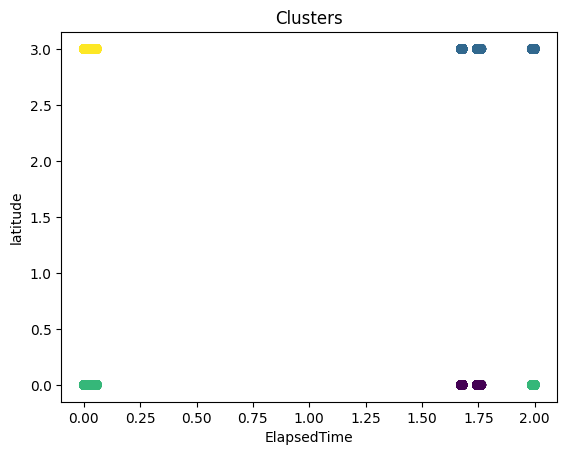

In [4]:
from sklearn.cluster import KMeans
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#Assigning custom weights to each feature

features = columns_to_normalize = [
    "latitude",
    "longitude",
    "datetime_sin",
    "datetime_cos",
    "ElapsedTime",
    "MinWaitTime",
    "MaxWaitTime",
    "BagNumber",
    "MaxSpendingRange",
    "DropOffRange"
]

feature_weights = np.array([3.0, 3.0, 2.0, 2.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0])

#testign normalized vs standard scalar
df_normalized = pd.read_csv("normalized_synthetic_data.csv")
df_standard_scalar = pd.read_csv("standard_scalar_data.csv")
df_weighted_normalize = pd.DataFrame()
df_weighted_standardscalar = pd.DataFrame()

for i, feature in enumerate(features):
    df_weighted_normalize[feature] = df_normalized[feature] * feature_weights[i]
    df_weighted_standardscalar[feature] = df_standard_scalar[feature] * feature_weights[i]

df_weighted_normalize.to_csv("normalized_synthetic_data.csv", index=False)
df_weighted_standardscalar.to_csv("standard_scalar_data.csv", index=False)


# Apply KMeans clustering
kmeans = KMeans(n_clusters=4, random_state=42, n_init='auto')
df_weighted_normalize['cluster'] = kmeans.fit_predict(df_weighted_normalize)
df_weighted_standardscalar['cluster'] = kmeans.fit_predict(df_weighted_standardscalar)

# Save the clustered dataset
df_weighted_normalize.to_csv("clustered_flight_data.csv", index=False)
df_weighted_standardscalar.to_csv("clustered_standard_scalar_data.csv", index=False)


#plotting normalized clusters
plt.scatter(df_weighted_normalize['ElapsedTime'], df_weighted_normalize['latitude'], c=df_weighted_normalize['cluster'], cmap='viridis') # Color points by cluster
plt.xlabel('ElapsedTime')
plt.ylabel('latitude')
plt.title('Clusters')
plt.show()



In [ ]:
import altair as alt
import pandas as pd

alt.data_transformers.disable_max_rows()


# Load clustered data
df = pd.read_csv("clustered_flight_data.csv")

df['cluster'] = df['cluster'].astype(str)

# Select 2D features for the plot (you can switch to PCA/t-SNE later)
x_feature = 'ElapsedTime'
y_feature = 'latitude'

# Build the interactive plot
chart = alt.Chart(df).mark_circle(size=60).encode(
    x=alt.X(x_feature, title=x_feature),
    y=alt.Y(y_feature, title=y_feature),
    color=alt.Color('cluster:N', title='Cluster'),
    tooltip=[
        'cluster:N',
        'latitude', 'longitude',
        'datetime_sin', 'datetime_cos',
        'ElapsedTime', 'MinWaitTime', 'MaxWaitTime',
        'BagNumber', 'MaxSpendingRange', 'DropOffRange'
    ]
).properties(
    title=f'Clusters Visualized: {x_feature} vs {y_feature}',
    width=700,
    height=500
).interactive()

chart
